## Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
sns.set_palette('deep')
plt.style.use('seaborn-notebook')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


# Titanic: Machine Learning from Disaster

Our goal is predict if a passenger survived or not to the Titanic shipwreck. Hence this a supervised classification problem. Let's look at the dataset.

## Load data

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

train.shape, test.shape

((891, 12), (418, 11))

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploring the data

Attributes:
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

### Numerical features

In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


PassengerId is useless for the machine learning model so let's take a look to the other attributes.

* ### Survived

In [5]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [6]:
train['Survived'].value_counts()/train.shape[0]*100

0    61.616162
1    38.383838
Name: Survived, dtype: float64

* This is the target variable.
* 38% passengers survived. We can use accuracy as metric for evaluate our model.

* ### Age

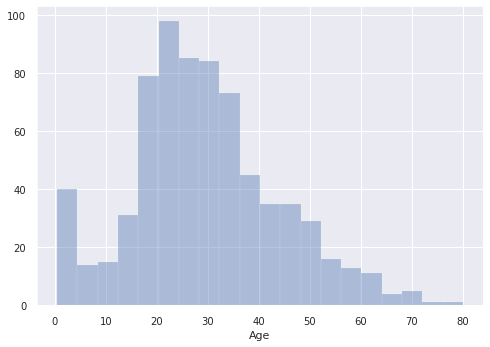

In [7]:
sns.distplot(train['Age'],kde=False);

* ### Fare

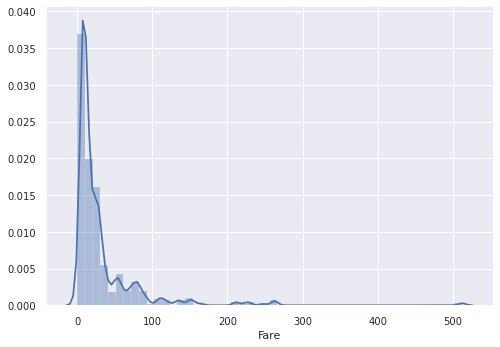

In [8]:
sns.distplot(train['Fare'], kde=False);

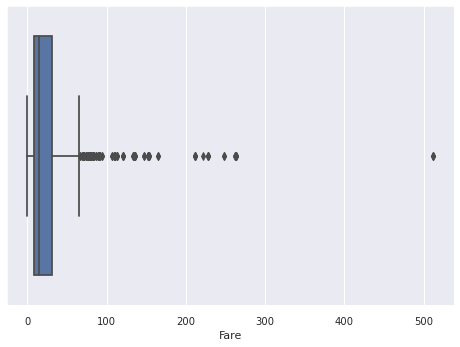

In [9]:
sns.boxplot(train['Fare']);

* High skewness to the right. This attribute has many outliers

* ### SibSp and Parch

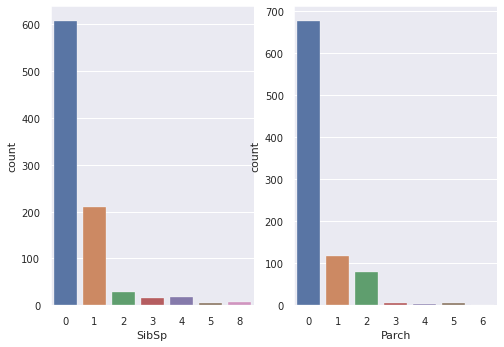

In [10]:
f, ax = plt.subplots(1, 2)
sns.countplot(train['SibSp'], ax=ax[0])
sns.countplot(train['Parch'], ax=ax[1]);

### Categorical attributes

* ### Pclass

In [11]:
train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

* Values: 1 = 1st class, 2 = 2nd class, 3 = 3rd class
* This indicates social/economic level of the passenger so probably influences survival rate.

* ### Name

In [12]:
train['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

* Useless attribute for prediction purposes by itself. Although we could extract the title of each passenger as a new feature.

* ### Sex

In [13]:
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

* ### Embarked

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

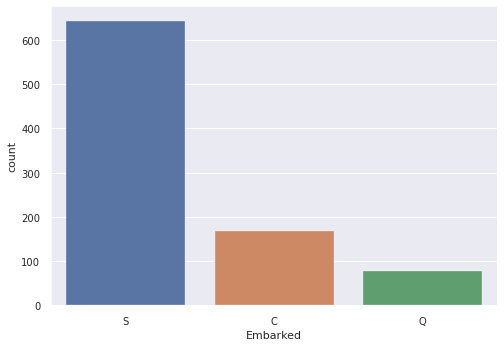

In [14]:
sns.countplot(train['Embarked']);
train['Embarked'].value_counts(normalize=True)

* Values: S = Southampton, C = Cherbourg, Q = Queenstown
* Over 72% of the passengers embarked from Southampton, 18% from Cherbourg and the rest from Queenstown

* ### Ticket

In [15]:
train['Ticket'].unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012

* Maybe we can extract some new feature from this

* ### Cabin

In [16]:
train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

* We could create a new feature extracting the letter of each cabin.

## Looking for correlations

Let's see how relates each variable with the target.

In [17]:
corr = train.corr()
corr['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

**Fare** and **Pclass** have the higher correlation with the target variable.

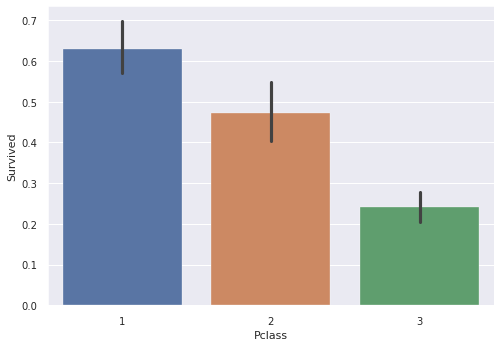

In [18]:
sns.barplot('Pclass', 'Survived', data=train);

Yes, there is a negative correlation

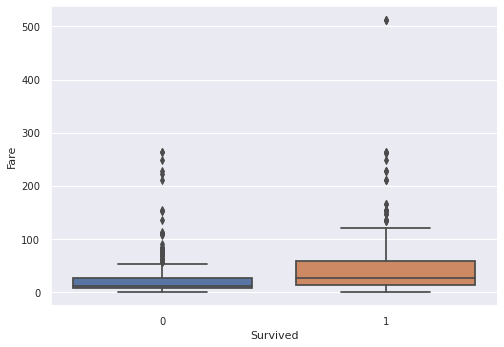

In [19]:
sns.boxplot('Survived', 'Fare', data=train);

High fare tends to more survival rate.

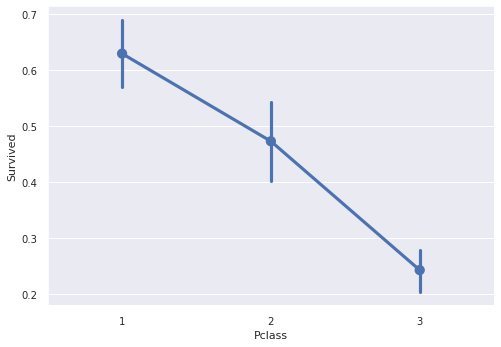

In [20]:
sns.pointplot('Pclass', 'Survived', data=train);

### Categorical
Embarked vs Survived

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

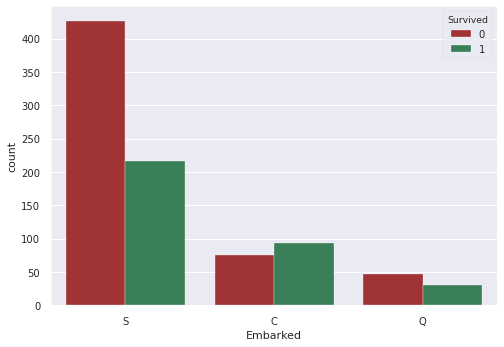

In [21]:
sns.countplot('Embarked', hue='Survived', data=train, palette=['firebrick', 'seagreen']);
train.groupby('Embarked')['Survived'].mean()

* Passengers from Southampton have low survival rate of 34%, while those from the port of Cherbourg have a survival rate of 55%

Is there a correlation between Embarked and Survived, or there are another variable interfering? Let's see other variables like Sex or Pclass

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


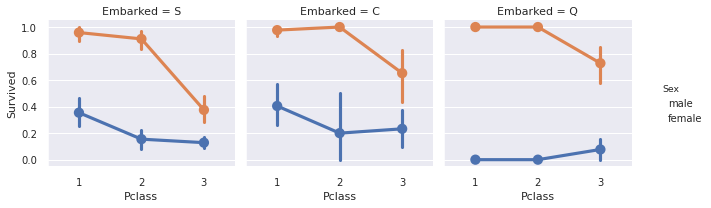

In [22]:
g = sns.FacetGrid(train,  col="Embarked", hue='Sex');
g.map(sns.pointplot, "Pclass", "Survived");
g.add_legend();

In [23]:
train.groupby(['Embarked', 'Sex'])['Survived'].count()

Embarked  Sex   
C         female     73
          male       95
Q         female     36
          male       41
S         female    203
          male      441
Name: Survived, dtype: int64

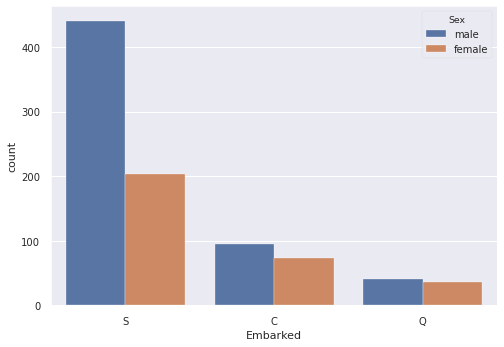

In [24]:
sns.countplot('Embarked', hue='Sex', data=train);

*  Embarked seems to be correlated with survival, depending on the gender.

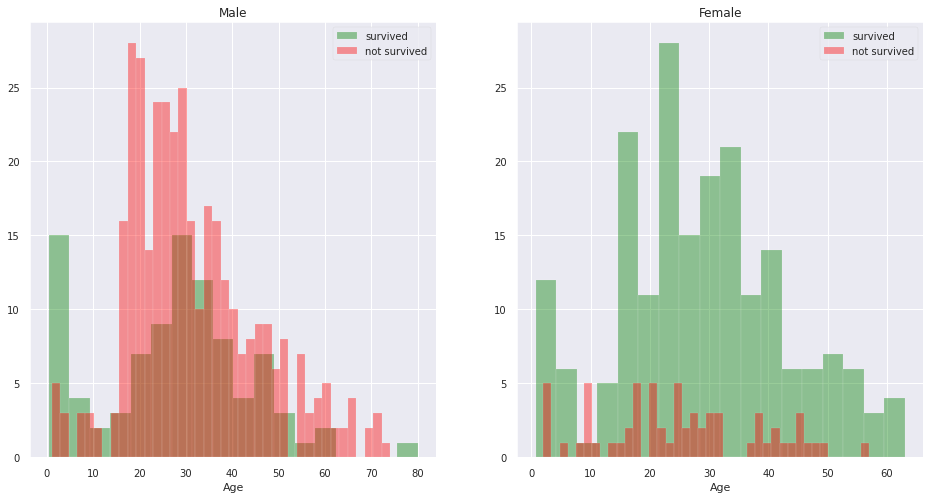

In [25]:
fig, ax = plt.subplots(1,2,figsize=(16, 8));
# Male
males = train[train['Sex'] == 'male']
sns.distplot(males[males['Survived'] == 1]['Age'], ax=ax[0],bins=18, color='green', label='survived', kde=False);
sns.distplot(males[males['Survived'] == 0]['Age'], ax=ax[0],bins=40, color='red', label='not survived', kde=False);
ax[0].legend();
ax[0].set_title('Male')
# Female
females = train[train['Sex'] == 'female']
sns.distplot(females[females['Survived'] == 1]['Age'],bins=18, ax=ax[1], color='green', label='survived',kde=False);
sns.distplot(females[females['Survived'] == 0]['Age'], bins=40,ax=ax[1], color='red', label='not survived', kde=False);
ax[1].legend();
ax[1].set_title('Female');


* Men below the age 10 and between 30 and 35 have a higher survival rate. 
* Women in general seem to have a high survival rate across age groups compared to that of men.
* Since there seem to be certain ages, which have increased odds of survival, we can create age groups later on.

## Prepare the data

### Missing values

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* Age: we can impute the median
* Embarked: just two missing values, we'll impute the most frequent value.
* Cabin: Too many values are missing (around 77%), we will ignore this attribute for now.

### Feature engineering

New features we'll use:
* Family: Sibsp + Parch
* Alone: using new family feature
* Title: Extracted from Name attr.

In [27]:
titles_dict = {
    "Capt": "Other",
    "Col": "Other",
    "Major": "Other",
    "Jonkheer": "Other",
    "Don": "Other",
    "Sir" : "Other",
    "Dr": "Other",
    "Rev": "Other",
    "the Countess":"Other",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Other"
}


def add_new_features(df):
    # Family
    df['Family'] = df['Parch'] + df['SibSp']
    # Alone
    df['Alone'] = df['Family'].apply(lambda x: 'Yes' if x > 0 else 'No')
    # Title
    titles = df['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
    df['Title'] = titles.map(titles_dict)
    
    return df

In [28]:
add_new_features(train)
add_new_features(test)
train.shape, test.shape

((891, 15), (418, 14))

In [29]:
train['Title'].value_counts()

Mr        517
Miss      184
Mrs       127
Master     40
Other      23
Name: Title, dtype: int64

In [30]:
test['Title'].value_counts()

Mr        240
Miss       78
Mrs        73
Master     21
Other       5
Name: Title, dtype: int64

In [31]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Family', 'Alone',
       'Title'],
      dtype='object')

* Do the passengers have better chance at survival while travelling alone?

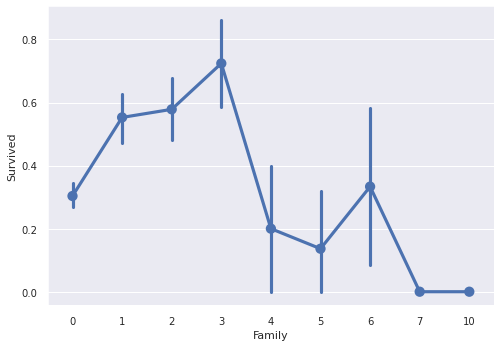

In [32]:
sns.pointplot('Family', 'Survived', data=train);

* It seems that travelling with 1-3 relatives has higher suvival rate than travel alone or with more than 3 relatives.

Transformation pipeline

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler

num_attribs = ['Age', 'Fare','Family']
cat_attribs = ['Embarked', 'Pclass', 'Title','Sex', 'Alone']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

In [34]:
X_train = full_pipeline.fit_transform(train.drop('Survived', axis=1))
X_train.shape

(891, 18)

In [35]:
y_train = train['Survived'].copy()

## Model building

In [36]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

In [38]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(log_reg, X_train, y_train, cv=10, scoring='accuracy')

In [39]:
scores.mean()

0.8260549313358302

### Hyperparameter tuning

In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'C': [1, 10, 30, 100, 300, 1000, 3000, 10000, 30000]}
]
grid_search = GridSearchCV(log_reg, param_grid, cv=10)

In [41]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid=[{'C': [1, 10, 30, 100, 300, 1000, 3000, 10000,
                                30000]}])

In [57]:
grid_search.best_score_, grid_search.best_params_

(0.8260549313358302, {'C': 1})

RandomForest

In [44]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

In [45]:
scores = cross_val_score(rfc, X_train, y_train, cv=10)
scores.mean()

0.8059176029962547

In [46]:
param_grid_rf = [{
    'max_depth' : [4, 6, 8],
    'n_estimators': [50, 10],
    'max_features': ['sqrt', 'auto', 'log2'],
    'min_samples_split': [2, 3, 10],
    'min_samples_leaf': [1, 3, 10],
    'bootstrap': [True, False]
}]
grid_search_rf = GridSearchCV(rfc, param_grid_rf, cv=5, verbose=1)

In [47]:
%%time
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 1min 11s, sys: 494 ms, total: 1min 12s
Wall time: 1min 12s


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  1.2min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'bootstrap': [True, False], 'max_depth': [4, 6, 8],
                          'max_features': ['sqrt', 'auto', 'log2'],
                          'min_samples_leaf': [1, 3, 10],
                          'min_samples_split': [2, 3, 10],
                          'n_estimators': [50, 10]}],
             verbose=1)

In [48]:
grid_search_rf.best_score_, grid_search_rf.best_estimator_

(0.836137091205825,
 RandomForestClassifier(max_depth=8, min_samples_split=10, n_estimators=50))

In [49]:
final_model = grid_search_rf.best_estimator_

### Test Set

In [50]:
train.shape, test.shape

((891, 15), (418, 14))

In [51]:
X_test = full_pipeline.transform(test)

In [52]:
X_train.shape, X_test.shape

((891, 18), (418, 18))

In [53]:
pred = final_model.predict(X_test) # 0.76

In [54]:
results_df = pd.DataFrame()
results_df['PassengerId'] = test['PassengerId']
results_df['Survived'] = pred

In [55]:
results_df.set_index('PassengerId', inplace=True)

In [56]:
results_df.to_csv('/kaggle/working/results.csv', index='PassengerId')